In [58]:
setwd("/Users/rebecca/sudmant/analyses/myotis/analysis/exploratory/species_peaks")

library(dplyr)
library(scales)
library(ggplot2)
library(data.table)

myo_meta <- read.csv("/Users/rebecca/sudmant/analyses/myotis/data/myotis_meta.csv")

## Get differential peak status between species in orthologous genes present in ALL species

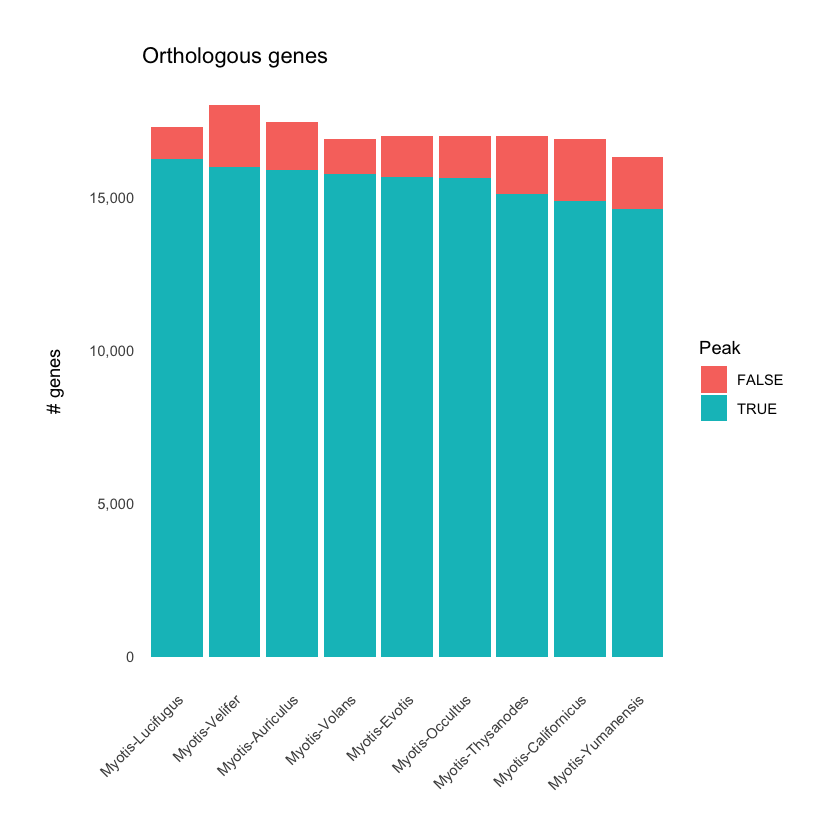

In [61]:
## Get # of genes with peaks in all species:

peak_ortho_files <- list.files(path = "results/data", 
                               pattern = "genes_5000.*orthologs_v2",
                               full.names = TRUE)

peak_gene_list <- lapply(seq_along(myo_meta$Abbr), function(i) {
  peak_ortho <- fread(peak_ortho_files[grep(myo_meta$Abbr[i], peak_ortho_files)], data.table = FALSE)
  df <- peak_ortho %>%
      dplyr::filter(Myotis_Alias != "") %>%
      dplyr::group_by(Myotis_Alias) %>%
      dplyr::reframe(Peak = paste(unique(Peak), collapse = ", ")) %>%
      dplyr::mutate(
        Peak = ifelse(grepl(",", Peak), TRUE, Peak),
        Species = myo_meta$Field_Name[i]
      )
  return(df)
})
df <- do.call(rbind, peak_gene_list)

df <- df %>%
  dplyr::group_by(Species, Peak) %>%
  dplyr::reframe(
    No.Genes = n()
  )
  
x_order <- df %>%
  dplyr::filter(Peak == TRUE) %>%
  dplyr::group_by(Species) %>%
  dplyr::reframe(n = sum(No.Genes)) %>%
  dplyr::arrange(desc(n))
  
df$Species <- factor(df$Species, levels = x_order$Species)

ggplot(df, aes(x = Species, y = No.Genes, fill = Peak)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  theme(axis.title.x = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.y = element_text(margin = margin(r = 15)),
        panel.grid = element_blank(),
        plot.margin = unit(c(1, 1, 1, 1), "cm")) +
  labs(title = "Genes with orthologs") +
  ylab("# genes") +
  scale_y_continuous(labels = comma)

In [60]:
## Get genes shared between all species:

gene_list <- lapply(seq_along(myo_meta$Abbr), function(i) {
  peak_ortho <- fread(peak_ortho_files[grep(myo_meta$Abbr[i], peak_ortho_files)], data.table = FALSE)
  return(unique(peak_ortho$Myotis_Alias[peak_ortho$Myotis_Alias != ""]))
})

shared_genes <- Reduce(intersect, gene_list)
length(shared_genes)

[1] 13774

In [77]:
## Get peak status of shared genes:

gene_peak_list <- lapply(seq_along(myo_meta$Abbr), function(i) {
  peak_ortho <- fread(peak_ortho_files[grep(myo_meta$Abbr[i], peak_ortho_files)], data.table = FALSE)
  peak_ortho <- peak_ortho %>%
    dplyr::filter(Myotis_Alias %in% shared_genes) %>%
    dplyr::group_by(Myotis_Alias) %>%
    dplyr::reframe(Peak = ifelse(
      sum(Peak) > 0, TRUE, FALSE
    ))
  return(unique(peak_ortho$Myotis_Alias[peak_ortho$Peak == TRUE]))
})
names(gene_peak_list) <- myo_meta$Field_Name

spec_peak_status <- as.data.frame.matrix(table(stack(gene_peak_list)))

In [84]:
## Cluster species by their peak status:

library(ComplexHeatmap)

cor_mat <- cor(spec_peak_status)
diag(cor_mat) <- NA

n_genes <- nrow(spec_peak_status)

plot_title <- paste("Peak status over", comma(n_genes), "shared orthologous genes")

pdf(file = paste0("results/figures/gene_peak_status_correlation_heatmap_v2.pdf"), width = 11, height = 9)

print(
  ComplexHeatmap::Heatmap(name = "Peak status correlation", 
                          column_title = plot_title,
                          matrix = cor_mat, 
                          clustering_method_rows = "average",
                          clustering_method_columns = "average",
                          column_names_rot = 45)
)

dev.off()

# pdf(file = paste0("results/figures/gene_peak_status_heatmap.pdf"), width = 9, height = 9)

# print(
#   ComplexHeatmap::Heatmap(name = "Peak status", 
#                           column_title = plot_title,
#                           matrix = spec_peak_status, 
#                           clustering_method_rows = "average",
#                           clustering_method_columns = "average",
#                           show_row_names = FALSE,
#                           column_names_rot = 45)
# )

# dev.off()

pdf 
  2